# Signal Decomposition: ML algorithms
## Author: Javier Gamero Muñoz

In this notebook a few ML models will be applied to the preprocessed data in 
order to try to decompose the total time serie and extract the part 
corresponding to the $e$.

**Table of contents**<a id='toc0_'></a>    
- 1. [General Libraries](#toc1_)    
- 2. [Load data](#toc2_)    
- 3. [Processing data](#toc3_)    
- 4. [ML Algorithms](#toc4_)    
  - 4.1. [KNN](#toc4_1_)    
  - 4.2. [SVM](#toc4_2_)    
    - 4.2.1. [Without muon serie](#toc4_2_1_)    
    - 4.2.2. [Muon signal added as a feature (ideal)](#toc4_2_2_)    
    - 4.2.3. [Looking for better parameters (Grid Search)](#toc4_2_3_)    
    - 4.2.3. [Test with real world data](#toc4_2_4_)

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[General Libraries](#toc0_)

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# 2. <a id='toc2_'></a>[Load data](#toc0_)

First, we load the idxs of the signals that contains the electron:

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

In [3]:
idx_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
idxs = pd.read_csv(idx_path, sep=';', header=None)
idxs = np.array(idxs.iloc[:,0]).reshape(-1)
idxs

array(['0_1', '0_4', '0_6', ..., '399_42', '399_43', '399_48'],
      dtype=object)

In [4]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t.set_index(0, inplace=True)

In [5]:
t0 = 150 # (ns), moment to start considering the slow component, EXPERIMENTAL
t_idx = np.where(t>t0)[1] 

In [6]:
t = np.array(t.iloc[0, t_idx]).reshape(-1) #1D array from t0 and on

In [7]:
e_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_e.csv')
e_signals = pd.read_csv(e_GT_path, sep=';', header=None, index_col=0)

mu_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_mu.csv')
mu_signals = pd.read_csv(mu_GT_path, sep=';', header=None, index_col=0)

# total signal: 
signals = mu_signals + e_signals

In [8]:
signals = signals.iloc[1:,:]
e_signals = e_signals.iloc[1:,:]

Function to create fasts plots of signals: 

In [9]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', 
                ylabel=r'# photons/$\Delta$t', c = ['r', 'b', 'g'], sep=False): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        plt.rcParams['font.size'] = str(16) 
        fig, axs = plt.subplots(1,len(v), figsize=(10,6))
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i], c=c[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.rcParams['font.size'] = str(16) 
        plt.figure(figsize=(8,6))
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75, c=c[i])
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return

0_9


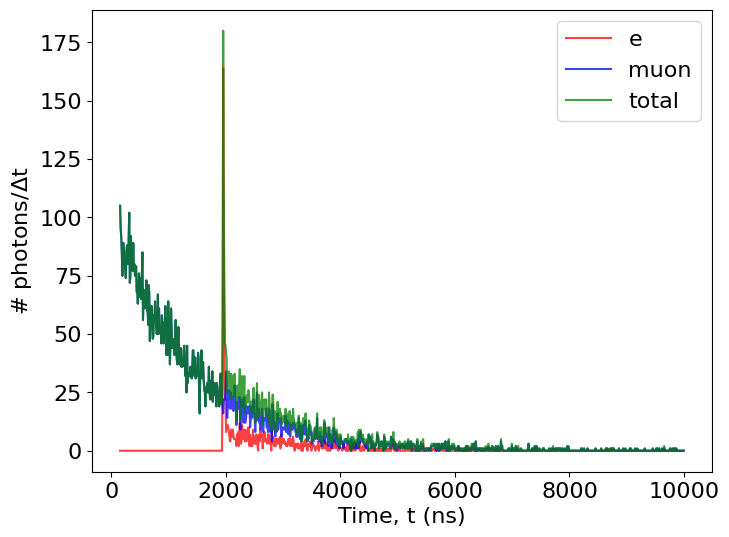

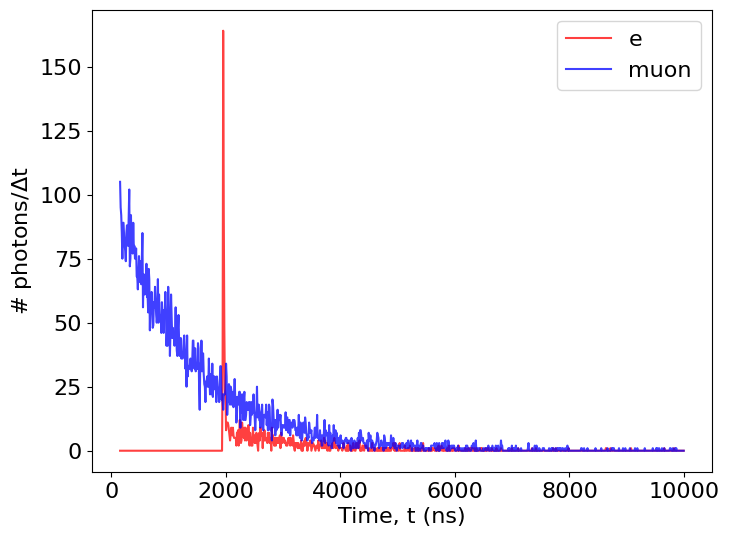

In [10]:
i = 4
print(idxs[i])
e_signal = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1)
mu_signal = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1)
signal = np.array(signals.loc[idxs[i], t_idx]).reshape(-1)

v = [e_signal, mu_signal, signal]
plotSignals(t, v, ['e', 'muon', 'total'])

v = [e_signal, mu_signal]
plotSignals(t, v, ['e', 'muon'])

# 3. <a id='toc3_'></a>[Processing data](#toc0_)

Here, we structure data so algorithms can make use of them. 

In [11]:
X = np.array(signals.iloc[:, t_idx].values)
y = np.array(e_signals.iloc[:, t_idx].values)
print(X.shape)
print(y.shape)

(20000, 985)
(20000, 985)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

Also, we process another stack of data removing signals whose max peak is lower 
than a threshold `max_photons`.

In [13]:
max_photons = 5
max_values = e_signals.max(axis=1)

mask = max_values > max_photons # True those with a maximum > max_photons
e_idxs = mask[mask==True].index.values

print('Total series: ', e_signals.shape[0])
print('Number of e signals with a max>{0}: {1}'.format(max_photons, e_idxs.shape[0]))

Total series:  20000
Number of e signals with a max>5: 11271


In [14]:
Xf = np.array(signals.loc[e_idxs, t_idx].values)
yf = np.array(e_signals.loc[e_idxs, t_idx].values)

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, 
                                                    test_size=0.3,
                                                    random_state=2023)

# 4. <a id='toc4_'></a>[ML Algorithms](#toc0_)

## 4.1. <a id='toc4_1_'></a>[KNN](#toc0_)

We begin with K-Nearest-Neighbours (KNN) algorithm from `sklearn`.  
Since this problem is trying to decompose a signal, it will be treated as a 
regression one. 

In [15]:
from sklearn.neighbors import KNeighborsRegressor

m0 = time()
knn = KNeighborsRegressor() # by default to check if it works
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Time spent training and predicting: {0}(s)'.format(time()-m0))

Time spent training and predicting: 1.259469985961914(s)


In [16]:
y_pred.shape

(6000, 985)

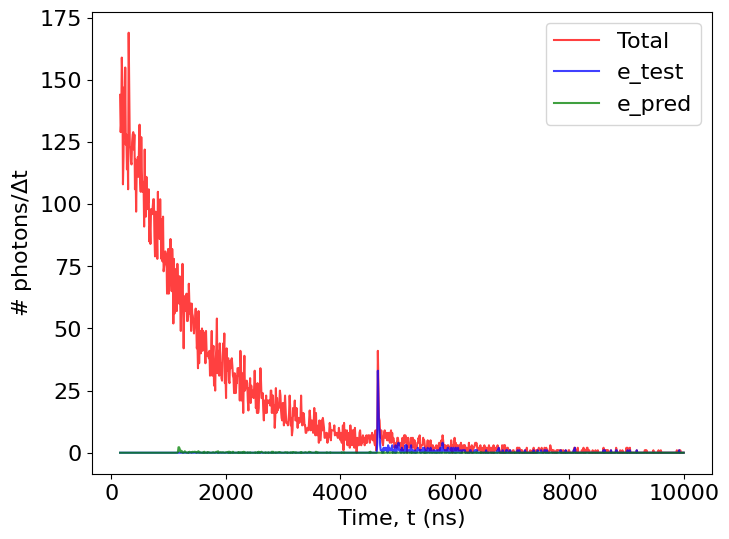

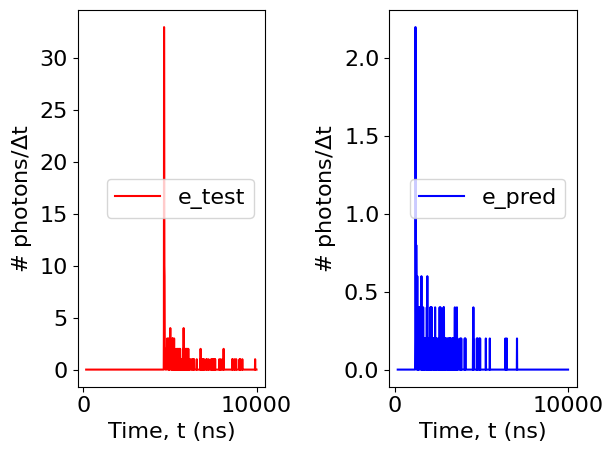

In [17]:
i = 6

v = [X_test[i,:], y_test[i,:], y_pred[i,:]]
plotSignals(t, v, ['Total', 'e_test', 'e_pred'], sep=False)

v = [y_test[i,:], y_pred[i,:]]
plotSignals(t, v, ['e_test', 'e_pred'], sep=True)

In [18]:
e_found = 0
for GT, pred in zip(y_test, y_pred): 
    q = quality(t, GT, pred)
    if q.isElectronExctracted(): e_found+=1
    
q = quality(t, y_test, y_pred)
print('MSE: ', q.mse())
print('Ratio e total found: {0}%'.format(e_found / y_test.shape[0] * 100))

MSE:  5.377086727580391
Ratio e total found: 41.91666666666667%


Let's try a 10-fold cross validation:

In [19]:
m0 = time()

knn = KNeighborsRegressor()
qual = quality(t)
r_train, r_test = qual.cross_validate(knn, X, y)

print('\nTime spent in cross-validation: {0}(s)'.format(time()-m0))

print('\nMean ratio of e found in test: {0}%'.format(np.mean(r_test)*100))
print('Mean ratio of e found in train: {0}%'.format(np.mean(r_train)*100))

Iterations of cv: 1/5
Iterations of cv: 2/5
Iterations of cv: 3/5
Iterations of cv: 4/5
Iterations of cv: 5/5

Time spent in cross-validation: 15.774747848510742(s)

Mean ratio of e found in test: 42.400000000000006%
Mean ratio of e found in train: 67.41875%


As we can see, the algorithm is failing to find the most of electrons and, also, 
it seems to be overfitting.  

First problem could happen due to the low signal of the electron in comparison with the 
total serie. Hence we use the data filtered, with signals where the $e$ does 
not have a maximum of 5 photons in one moment have been removed:

In [20]:
knn = KNeighborsRegressor() # by default to check if it works
knn.fit(Xf_train, yf_train)
yf_pred = knn.predict(Xf_test)

e_found = 0
for GT, pred in zip(yf_test, yf_pred): 
    q = quality(t, GT, pred)
    if q.isElectronExctracted(): e_found+=1
    
q = quality(t, yf_test, yf_pred)
print('MSE: ', q.mse())
print('Ratio e total found: {0}%'.format(e_found / yf_test.shape[0] * 100))

MSE:  8.944636153779228
Ratio e total found: 55.706682436428146%


Cross validation: 

In [22]:
m0 = time()

knn = KNeighborsRegressor()
qual = quality(t)
r_train, r_test = qual.cross_validate(knn, Xf, yf)

print('\nTime spent in cross-validation: {0}(s)'.format(time()-m0))

print('\nMSE train: ', np.mean(qual.mse_list_train))
print('MSE: test', np.mean(qual.mse_list))
print('Mean ratio of e found in test: {0}%'.format(np.mean(r_test)*100))
print('Mean ratio of e found in train: {0}%'.format(np.mean(r_train)*100))

Iterations of cv: 1/5
Iterations of cv: 2/5
Iterations of cv: 3/5
Iterations of cv: 4/5
Iterations of cv: 5/5

Time spent in cross-validation: 5.9441001415252686(s)

MSE train:  6.2312598065932
MSE: test 8.506510887255633
Mean ratio of e found in test: 56.49667405764966%
Mean ratio of e found in train: 79.62511091393078%


The problems have not dissapear.  
Let's try a GridSearch around the parameters, creating a table to see what 
configuration is the best and if, the result may be enhanced.

In [23]:
n_neighbors=[3,4,5]
metrics=['cityblock', 'cosine', 'euclidean']
e_found=0

q = quality(t)
for n in n_neighbors:
    for metric in metrics: 
        knn = KNeighborsRegressor(n_neighbors=n, metric=metric, n_jobs=-1)
        r_train, r_result = q.getScore(knn, X, y)
        print('N neighbors: {0}, metric: {1}, trainScore: {2}, testScore: {3}'.format(n, metric, r_train, r_result))
        print('MSE train: ', np.mean(q.mse_list_train))
        print('MSE: test', np.mean(q.mse_list))
        print()
        

N neighbors: 3, metric: cityblock, trainScore: 0.795, testScore: 0.37025
MSE train:  3.6155651015228316
MSE: test 7.247005047941331

N neighbors: 3, metric: cosine, trainScore: 0.65925, testScore: 0.42525
MSE train:  3.155042110829089
MSE: test 5.02507072758037

N neighbors: 3, metric: euclidean, trainScore: 0.7785625, testScore: 0.4635
MSE train:  2.338320480823451
MSE: test 4.366382769317538

N neighbors: 4, metric: cityblock, trainScore: 0.7315625, testScore: 0.35375
MSE train:  4.675828596922589
MSE: test 7.429692544416244

N neighbors: 4, metric: cosine, trainScore: 0.5891875, testScore: 0.407
MSE train:  3.4220816822652287
MSE: test 4.696857566624367

N neighbors: 4, metric: euclidean, trainScore: 0.718125, testScore: 0.43625
MSE train:  3.061905956535533
MSE: test 4.561944273477158

N neighbors: 5, metric: cityblock, trainScore: 0.6881875, testScore: 0.33975
MSE train:  5.448260944162458
MSE: test 7.542360274111692

N neighbors: 5, metric: cosine, trainScore: 0.546625, testScore

In [24]:
n_neighbors=[3,4,5]
metrics=['cityblock', 'cosine', 'euclidean']
e_found=0

q = quality(t)
for n in n_neighbors:
    for metric in metrics: 
        knn = KNeighborsRegressor(n_neighbors=n, metric=metric, n_jobs=-1)
        r_train, r_result = q.getScore(knn, Xf, yf)
        print('N neighbors: {0}, metric: {1}, trainScore: {2}, testScore: {3}'.format(n, metric, r_train, r_result))
        print('MSE train: ', np.mean(q.mse_list_train))
        print('MSE: test', np.mean(q.mse_list))
        print()

N neighbors: 3, metric: cityblock, trainScore: 0.8239795918367347, testScore: 0.4337028824833703
MSE train:  6.006401591755632
MSE: test 11.96320701130407

N neighbors: 3, metric: cosine, trainScore: 0.7634205856255546, testScore: 0.6363636363636364
MSE train:  4.6418331814444285
MSE: test 7.948133708009899

N neighbors: 3, metric: euclidean, trainScore: 0.8396184560780834, testScore: 0.5583148558758315
MSE train:  4.090131087379392
MSE: test 7.877787807504287

N neighbors: 4, metric: cityblock, trainScore: 0.7927018633540373, testScore: 0.4465631929046563
MSE train:  7.681927412462447
MSE: test 12.159395139959706

N neighbors: 4, metric: cosine, trainScore: 0.7400177462289264, testScore: 0.6399113082039911
MSE train:  5.220731397143937
MSE: test 7.434373163978525

N neighbors: 4, metric: euclidean, trainScore: 0.8133318544809228, testScore: 0.5614190687361419
MSE train:  5.294576322859755
MSE: test 8.172543839409322

N neighbors: 5, metric: cityblock, trainScore: 0.7694099378881988, t

It does not improve in any case...  
Cross validation for a better statistical result.

In [22]:
n_neighbors=[3,4,5]
metrics=['cityblock', 'cosine', 'euclidean']
e_found=0

q = quality(t)
for n in n_neighbors:
    for metric in metrics: 
        knn = KNeighborsRegressor(n_neighbors=n, metric=metric, n_jobs=-1)
        r_train, r_result = q.cross_validate(knn, X, y, verbose=0)
        print('N neighbors: {0}, metric: {1}, trainScore: {2}, testScore: {3}'.format(n, metric, np.mean(r_train), np.mean(r_result)))

N neighbors: 3, metric: cityblock, trainScore: 0.7509383378016086, testScore: 0.2675603217158177
N neighbors: 3, metric: cosine, trainScore: 0.6310991957104558, testScore: 0.303485254691689
N neighbors: 3, metric: euclidean, trainScore: 0.7348525469168901, testScore: 0.34959785522788206
N neighbors: 4, metric: cityblock, trainScore: 0.6848525469168901, testScore: 0.24986595174262732
N neighbors: 4, metric: cosine, trainScore: 0.5603217158176944, testScore: 0.2809651474530831
N neighbors: 4, metric: euclidean, trainScore: 0.6733243967828418, testScore: 0.33404825737265414
N neighbors: 5, metric: cityblock, trainScore: 0.6361930294906166, testScore: 0.24450402144772115
N neighbors: 5, metric: cosine, trainScore: 0.5203753351206434, testScore: 0.2707774798927614
N neighbors: 5, metric: euclidean, trainScore: 0.6335120643431635, testScore: 0.32386058981233246


In [26]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor() # by default to check if it works
n_neighbors=[50,100,200]
metrics=['cityblock', 'cosine', 'euclidean']
e_found=0

q = quality(t)
for n in n_neighbors:
    for metric in metrics: 
        knn = KNeighborsRegressor(n_neighbors=n, metric=metric, n_jobs=-1)
        r_train, r_result = q.cross_validate(knn, Xf, yf, verbose=0)
        print('N neighbors: {0}, metric: {1}, trainScore: {2}, testScore: {3}'.format(n, metric, np.mean(r_train), np.mean(r_result)))
        print('MSE train: ', np.mean(q.mse_list_train))
        print('MSE: test', np.mean(q.mse_list))
        print()

N neighbors: 50, metric: cityblock, trainScore: 0.5902839396628217, testScore: 0.5024390243902439
MSE train:  17.05511115440543
MSE: test 15.986415402478379

N neighbors: 50, metric: cosine, trainScore: 0.6820097604259094, testScore: 0.647450110864745
MSE train:  11.73875898607763
MSE: test 10.434915586029904

N neighbors: 50, metric: euclidean, trainScore: 0.6598269742679681, testScore: 0.5711751662971175
MSE train:  15.402775084069111
MSE: test 14.488080862966632

N neighbors: 100, metric: cityblock, trainScore: 0.5399290150842946, testScore: 0.4727272727272728
MSE train:  18.073421127200703
MSE: test 16.59876524191022

N neighbors: 100, metric: cosine, trainScore: 0.6623779946761313, testScore: 0.637250554323725
MSE train:  14.36790268987104
MSE: test 12.767731466003339

N neighbors: 100, metric: euclidean, trainScore: 0.6155723158828749, testScore: 0.5481152993348115
MSE train:  17.255707656067603
MSE: test 15.879930989093573

N neighbors: 200, metric: cityblock, trainScore: 0.4899

In [15]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(5, metric='cosine', n_jobs=-1)
knn.fit(Xf_train, yf_train)
yf_pred = knn.predict(Xf_test)

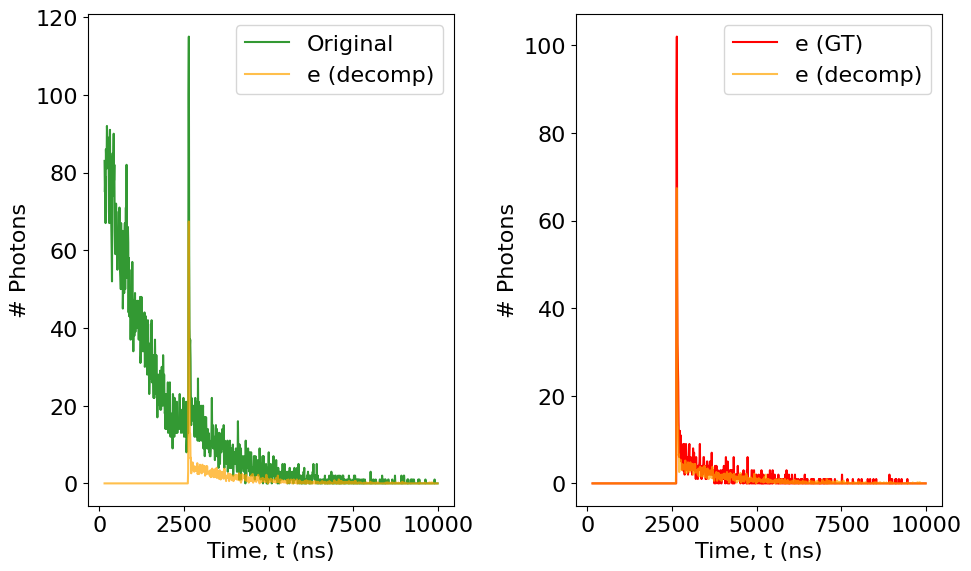

In [17]:
i =12

v = [yf_test[i,:], yf_pred[i,:]]
plt.rcParams['font.size'] = str(16) 
fig, axs = plt.subplots(1,2, figsize = (10,6))

axs[0].plot(t, Xf_test[i,:], c='g', label='Original', alpha=0.8)
axs[0].plot(t, yf_pred[i,:], c='orange', label='e (decomp)', alpha=0.7)
axs[0].set_xlabel('Time, t (ns)')
axs[0].set_ylabel('# Photons')
axs[0].legend(loc='best')   

axs[1].plot(t, yf_test[i,:], c='r', label='e (GT)')
axs[1].plot(t, yf_pred[i,:], c='orange', label='e (decomp)', alpha=0.7)
axs[1].set_xlabel('Time, t (ns)')
axs[1].set_ylabel('# Photons')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

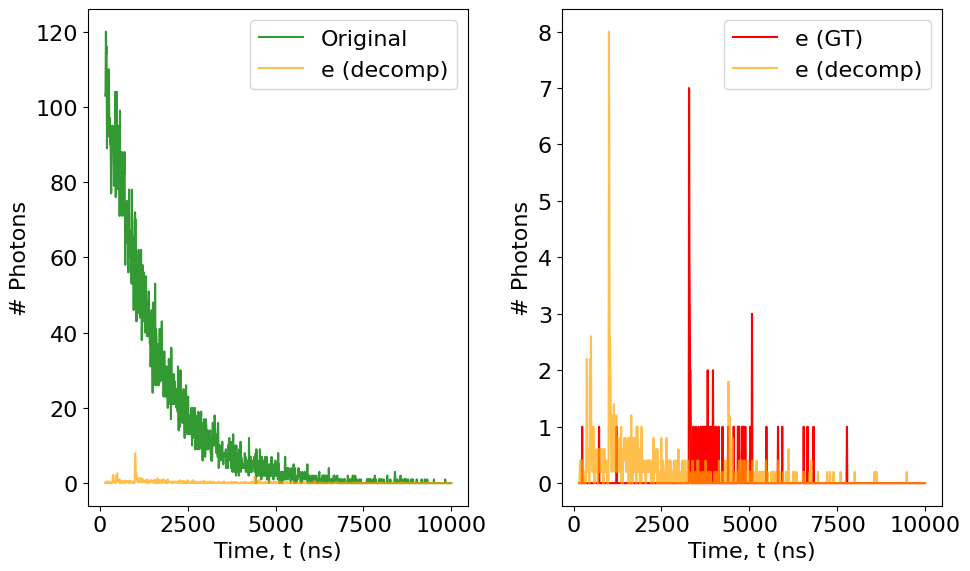

In [18]:
i=6

v = [yf_test[i,:], yf_pred[i,:]]
plt.rcParams['font.size'] = str(16) 
fig, axs = plt.subplots(1,2, figsize = (10,6))

axs[0].plot(t, Xf_test[i,:], c='g', label='Original', alpha=0.8)
axs[0].plot(t, yf_pred[i,:], c='orange', label='e (decomp)', alpha=0.7)
axs[0].set_xlabel('Time, t (ns)')
axs[0].set_ylabel('# Photons')
axs[0].legend(loc='best')   

axs[1].plot(t, yf_test[i,:], c='r', label='e (GT)')
axs[1].plot(t, yf_pred[i,:], c='orange', label='e (decomp)', alpha=0.7)
axs[1].set_xlabel('Time, t (ns)')
axs[1].set_ylabel('# Photons')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 4.2. <a id='toc4_2_'></a>[SVM](#toc0_)

### 4.2.1. <a id='toc4_2_1_'></a>[Without muon serie](#toc0_)

This is how the data would be inserted in real world:

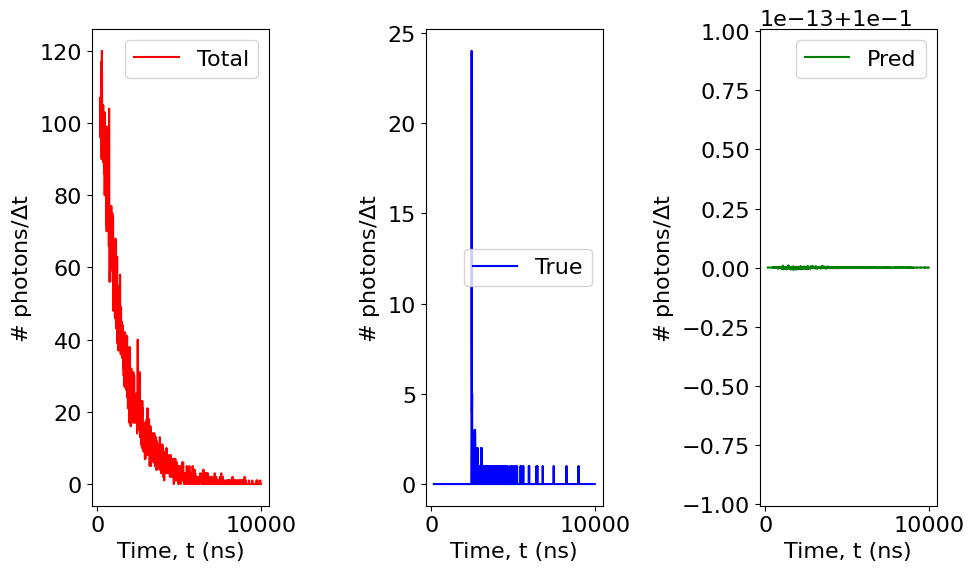

In [15]:
from sklearn.svm import SVR

i = 5
q = quality(t)
svm = SVR(kernel='rbf', C=1.0)
svm.fit(X_train[i,:].reshape(-1,1), y_train[i,:])
y_pred = svm.predict(X_train[8,:].reshape(-1,1))

v = [X_train[8,:], y_train[8,:], y_pred]
plotSignals(t, v, ['Total', 'True', 'Pred'], sep=True)

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1],
    'epsilon': [0.1, 0.2],
    'gamma': ['scale'] 
}

i=8

svm = SVR()
gs = GridSearchCV(svm, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1,
                  verbose=0)
gs.fit(Xf_train[i,:].reshape(-1,1), yf_train[i,:])

best_params = gs.best_params_
best_svr = gs.best_estimator_

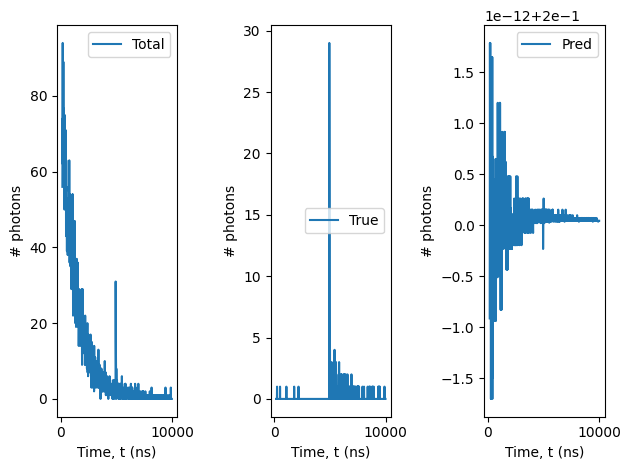

{'C': 0.1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}


In [58]:
j = 8
y_pred = best_svr.predict(X_train[j,:].reshape(-1,1))

v = [X_train[j,:], y_train[j,:], y_pred]
plotSignals(t, v, ['Total', 'True', 'Pred'], sep=True)
print(best_params)

This approach does not seem to be good enough, it does not even extract well 
enough the signal. 

In [18]:
params = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2,3,4],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.0001, 0.001, 0.01, 0.1]
}

gs = GridSearchCV(SVR(), params, scoring='neg_mean_squared_error', n_jobs=-1, 
                  cv=2, verbose=3)

i=8
gs.fit(Xf_train[i,:].reshape(-1,1), yf_train[i,:])
print(gs.best_params_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-101.337 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-101.292 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-0.931 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=sigmoid;, score=-101.341 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-95.738 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-0.928 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-0.937 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-101.332 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-101.149 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=sigmoid;, s

-44.31107367706588
4.527962776055056


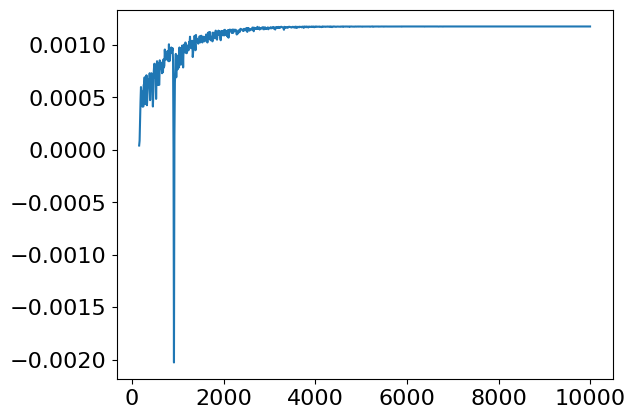

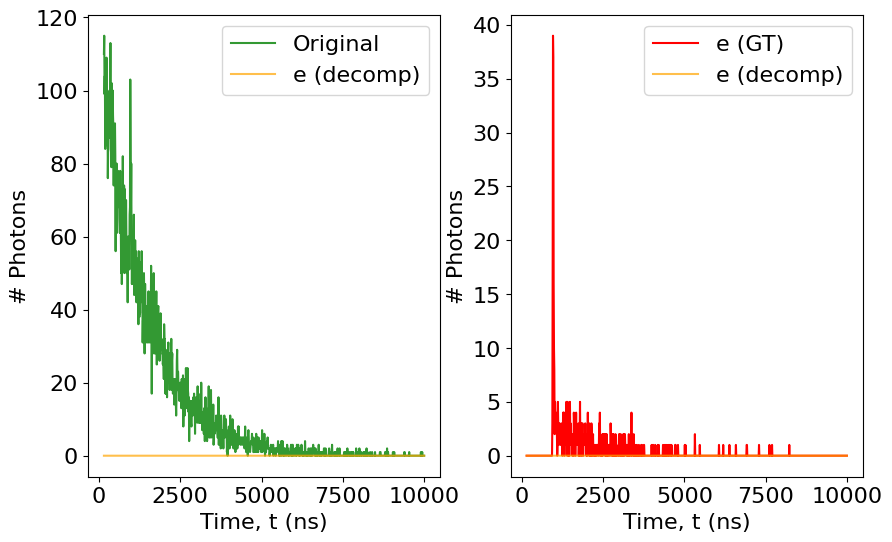

In [33]:
from sklearn.metrics import mean_squared_error
i=8
print(gs.best_score_)

best_svr = gs.best_estimator_
yf_pred = best_svr.predict(Xf_train[i,:].reshape(-1,1))
print(mean_squared_error(yf_test[i,:], yf_pred))

plt.plot(t, yf_pred)
plt.show()

plt.rcParams['font.size'] = str(16) 
fig, axs = plt.subplots(1,2, figsize = (10,6))

axs[0].plot(t, Xf_test[i,:], c='g', label='Original', alpha=0.8)
axs[0].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[0].set_xlabel('Time, t (ns)')
axs[0].set_ylabel('# Photons')
axs[0].legend(loc='best')   

axs[1].plot(t, yf_test[i,:], c='r', label='e (GT)')
axs[1].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[1].set_xlabel('Time, t (ns)')
axs[1].set_ylabel('# Photons')
axs[1].legend(loc='best')

In [34]:
params = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2,3,4],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.0001, 0.001, 0.01, 0.1]
}

gs = GridSearchCV(SVR(), params, scoring='neg_mean_squared_error', n_jobs=-1, 
                  cv=2, verbose=3)

i=12
gs.fit(Xf_train[i,:].reshape(-1,1), yf_train[i,:])
print(gs.best_params_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-95.158 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-0.394 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-95.153 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-95.153 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-95.158 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-0.395 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-0.922 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=poly;, score=-95.153 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=sigmoid;, score=-95.154 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=poly;, score=-0.92

-47.356716943725516
4.231851070717642


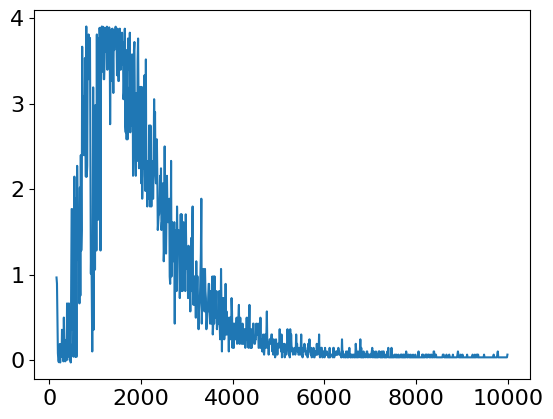

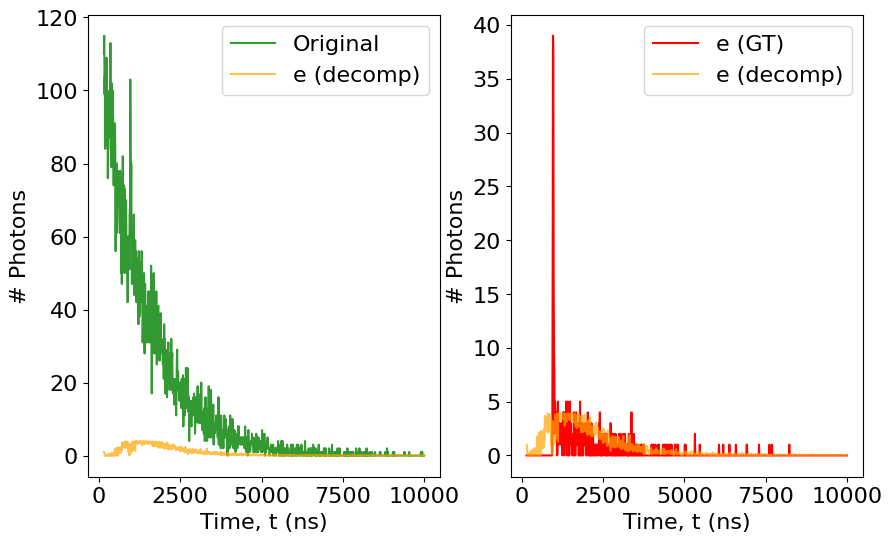

In [35]:
from sklearn.metrics import mean_squared_error
i=8
print(gs.best_score_)

best_svr = gs.best_estimator_
yf_pred = best_svr.predict(Xf_train[i,:].reshape(-1,1))
print(mean_squared_error(yf_test[i,:], yf_pred))

plt.plot(t, yf_pred)
plt.show()

plt.rcParams['font.size'] = str(16) 
fig, axs = plt.subplots(1,2, figsize = (10,6))

axs[0].plot(t, Xf_test[i,:], c='g', label='Original', alpha=0.8)
axs[0].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[0].set_xlabel('Time, t (ns)')
axs[0].set_ylabel('# Photons')
axs[0].legend(loc='best')   

axs[1].plot(t, yf_test[i,:], c='r', label='e (GT)')
axs[1].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[1].set_xlabel('Time, t (ns)')
axs[1].set_ylabel('# Photons')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-79.673 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-79.673 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-0.047 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-79.673 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=sigmoid;, score=-79.674 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-79.669 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-79.669 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-0.955 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=poly;, score=-79.669 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-0.

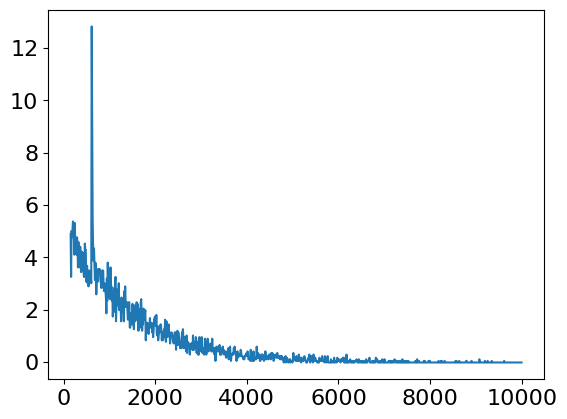

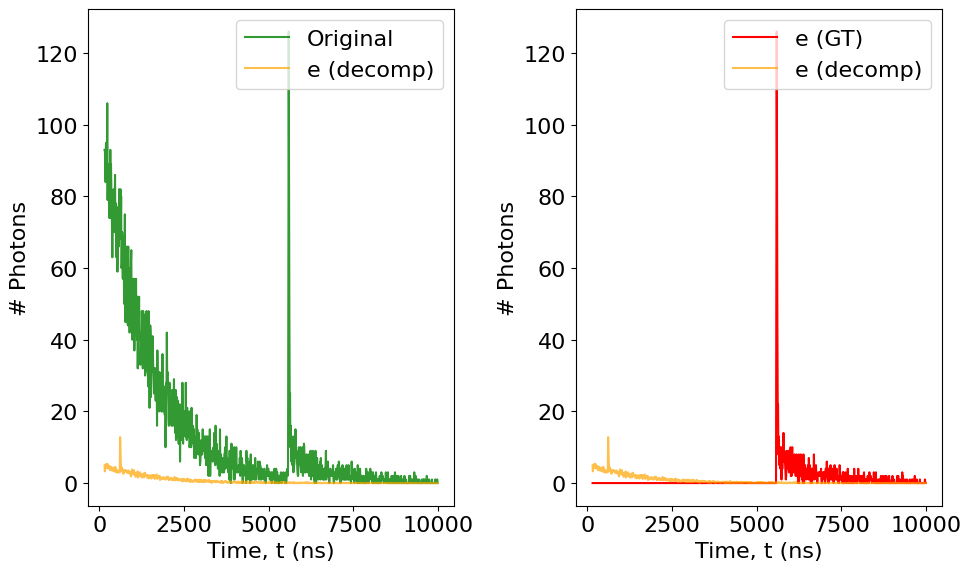

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

params = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2,3,4],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.0001, 0.001, 0.01, 0.1]
}

gs = GridSearchCV(SVR(), params, scoring='neg_mean_squared_error', n_jobs=-1, 
                  cv=2, verbose=3)


i=15
gs.fit(Xf_train[i,:].reshape(-1,1), yf_train[i,:])
print(gs.best_params_)
print(gs.best_score_)

best_svr = gs.best_estimator_
yf_pred = best_svr.predict(Xf_train[i,:].reshape(-1,1))
print(mean_squared_error(yf_test[i,:], yf_pred))

plt.plot(t, yf_pred)
plt.show()

plt.rcParams['font.size'] = str(16) 
fig, axs = plt.subplots(1,2, figsize = (10,6))

axs[0].plot(t, Xf_test[i,:], c='g', label='Original', alpha=0.8)
axs[0].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[0].set_xlabel('Time, t (ns)')
axs[0].set_ylabel('# Photons')
axs[0].legend(loc='best')   

axs[1].plot(t, yf_test[i,:], c='r', label='e (GT)')
axs[1].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[1].set_xlabel('Time, t (ns)')
axs[1].set_ylabel('# Photons')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-1.692 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-1.692 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-1.692 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-0.002 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=sigmoid;, score=-1.692 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-0.002 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-1.691 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-1.691 tota

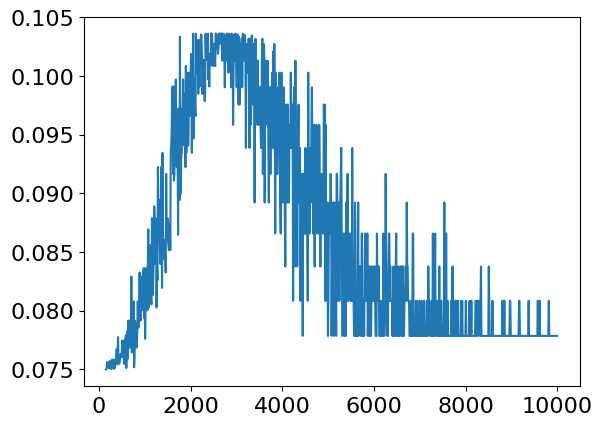

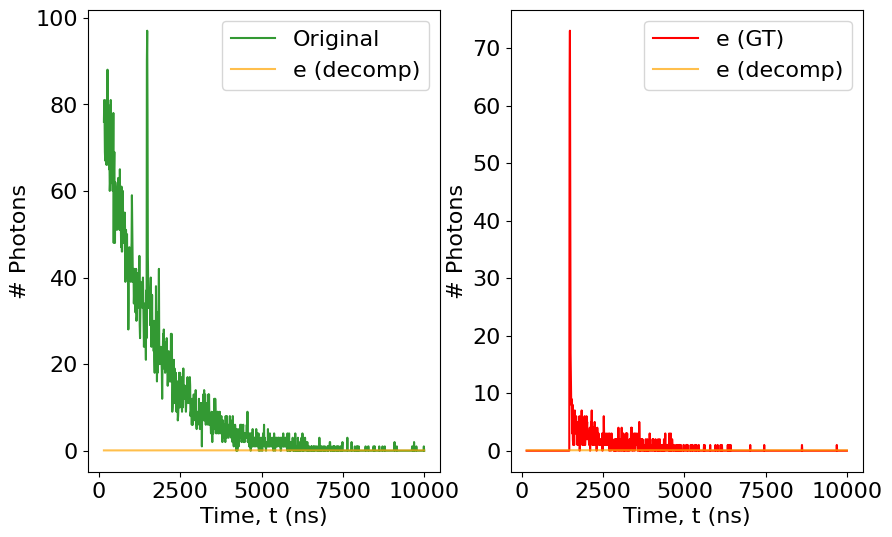

In [38]:
params = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2,3,4],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.0001, 0.001, 0.01, 0.1]
}

gs = GridSearchCV(SVR(), params, scoring='neg_mean_squared_error', n_jobs=-1, 
                  cv=2, verbose=3)


i=20
gs.fit(Xf_train[i,:].reshape(-1,1), yf_train[i,:])
print(gs.best_params_)
print(gs.best_score_)

best_svr = gs.best_estimator_
yf_pred = best_svr.predict(Xf_train[i,:].reshape(-1,1))
print(mean_squared_error(yf_test[i,:], yf_pred))

plt.plot(t, yf_pred)
plt.show()

plt.rcParams['font.size'] = str(16) 
fig, axs = plt.subplots(1,2, figsize = (10,6))

axs[0].plot(t, Xf_test[i,:], c='g', label='Original', alpha=0.8)
axs[0].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[0].set_xlabel('Time, t (ns)')
axs[0].set_ylabel('# Photons')
axs[0].legend(loc='best')   

axs[1].plot(t, yf_test[i,:], c='r', label='e (GT)')
axs[1].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[1].set_xlabel('Time, t (ns)')
axs[1].set_ylabel('# Photons')
axs[1].legend(loc='best')

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-37.164 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-37.100 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-35.804 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=sigmoid;, score=-37.165 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-1.037 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-37.160 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-0.216 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-37.098 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-0.223 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=poly;, score=-35.

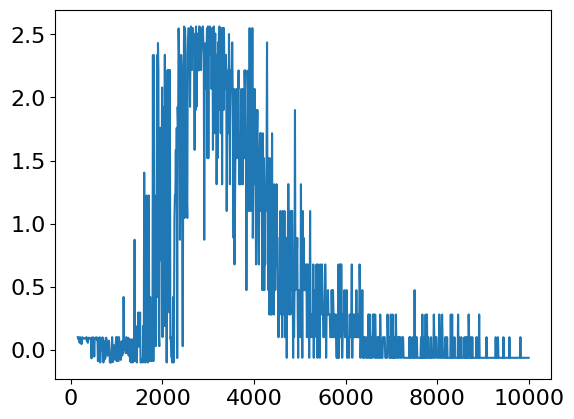

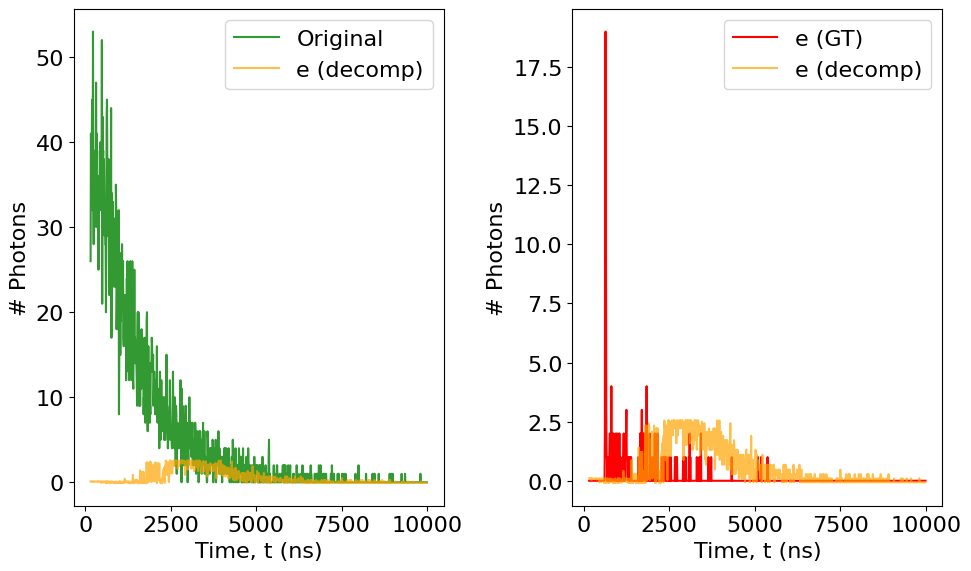

In [21]:
params = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2,3,4],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.0001, 0.001, 0.01, 0.1]
}

gs = GridSearchCV(SVR(), params, scoring='neg_mean_squared_error', n_jobs=-1, 
                  cv=2, verbose=3)


i=50
gs.fit(Xf_train[i,:].reshape(-1,1), yf_train[i,:])
print(gs.best_params_)
print(gs.best_score_)

best_svr = gs.best_estimator_
yf_pred = best_svr.predict(Xf_train[i,:].reshape(-1,1))
print(mean_squared_error(yf_test[i,:], yf_pred))

plt.plot(t, yf_pred)
plt.show()

plt.rcParams['font.size'] = str(16) 
fig, axs = plt.subplots(1,2, figsize = (10,6))

axs[0].plot(t, Xf_test[i,:], c='g', label='Original', alpha=0.8)
axs[0].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[0].set_xlabel('Time, t (ns)')
axs[0].set_ylabel('# Photons')
axs[0].legend(loc='best')   

axs[1].plot(t, yf_test[i,:], c='r', label='e (GT)')
axs[1].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[1].set_xlabel('Time, t (ns)')
axs[1].set_ylabel('# Photons')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=poly;, score=-58.095 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-58.095 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-58.095 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=sigmoid;, score=-0.004 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-2.073 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-0.004 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-58.093 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-0.004 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-58.093 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-2.07

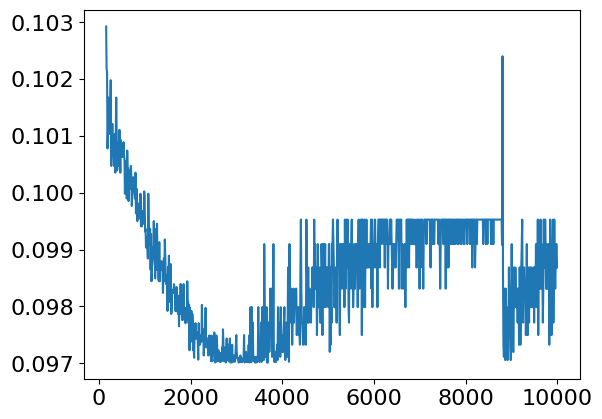

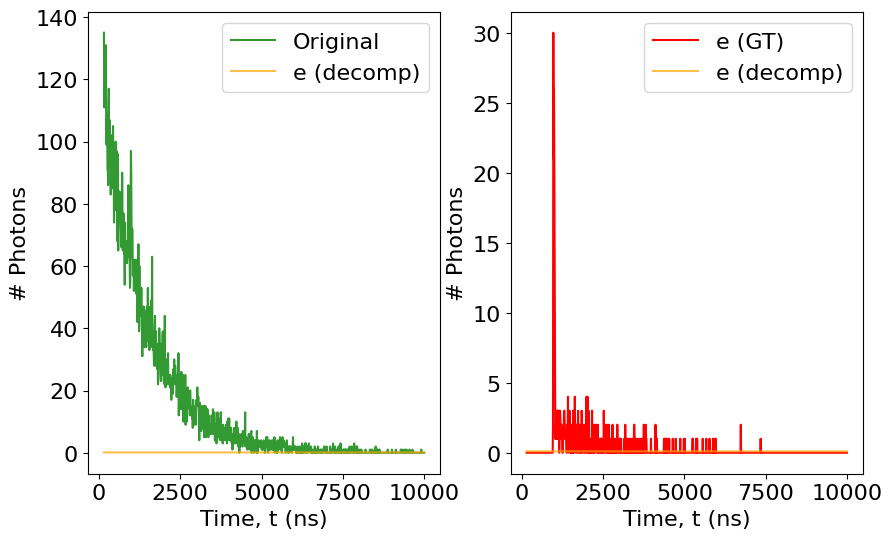

In [42]:
params = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2,3,4],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.0001, 0.001, 0.01, 0.1]
}

gs = GridSearchCV(SVR(), params, scoring='neg_mean_squared_error', n_jobs=-1, 
                  cv=2, verbose=3)


i=100
gs.fit(Xf_train[i,:].reshape(-1,1), yf_train[i,:])
print(gs.best_params_)
print(gs.best_score_)

best_svr = gs.best_estimator_
yf_pred = best_svr.predict(Xf_train[i,:].reshape(-1,1))
print(mean_squared_error(yf_test[i,:], yf_pred))

plt.plot(t, yf_pred)
plt.show()

plt.rcParams['font.size'] = str(16) 
fig, axs = plt.subplots(1,2, figsize = (10,6))

axs[0].plot(t, Xf_test[i,:], c='g', label='Original', alpha=0.8)
axs[0].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[0].set_xlabel('Time, t (ns)')
axs[0].set_ylabel('# Photons')
axs[0].legend(loc='best')   

axs[1].plot(t, yf_test[i,:], c='r', label='e (GT)')
axs[1].plot(t, yf_pred, c='orange', label='e (decomp)', alpha=0.7)
axs[1].set_xlabel('Time, t (ns)')
axs[1].set_ylabel('# Photons')
axs[1].legend(loc='best')

### 4.2.2. <a id='toc4_2_2_'></a>[Muon signal added as a feature (ideal)](#toc0_)

Let's try adding the temporal serie of the muon as a feature. We do this with 
the purpose of fitting a model with the calculated signal of the muon, since 
we checked that it can be fitted from the total one.

In [15]:
i = 8
Xexample_train = np.array([signals.iloc[i, t_idx].values, mu_signals.iloc[i, t_idx].values]).T
yexample_train = np.array(e_signals.iloc[i, t_idx].values).reshape(-1)

In [16]:
from sklearn.svm import SVR
svm = SVR(kernel='rbf', C=1.0)
svm.fit(Xexample_train, yexample_train)
y_pred = svm.predict(Xexample_train)

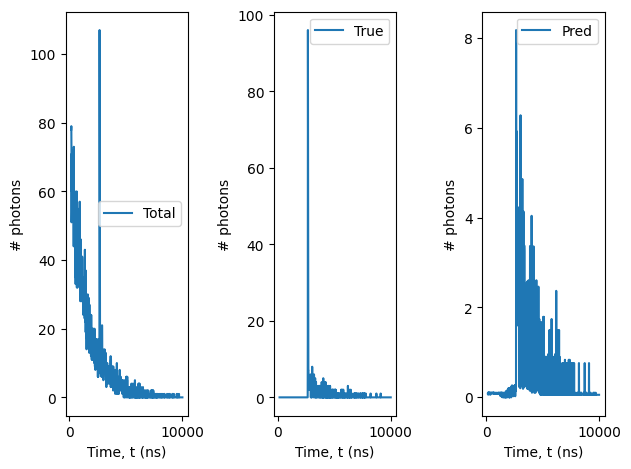

In [17]:
v = [Xexample_train[:,0], yexample_train, y_pred]
plotSignals(t, v, ['Total', 'True', 'Pred'], sep=True)

### 4.2.3. <a id='toc4_2_3_'></a>[Looking for better parameters (Grid Search)](#toc0_)

Although the model achieves to detect the electron, we could use a grid search to 
test if the model improves the high of the peak:

In [44]:
from sklearn.model_selection import GridSearchCV
params = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2,3,4],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.0001, 0.001, 0.01, 0.1]
}

gs = GridSearchCV(SVR(), params, scoring='neg_mean_squared_error', n_jobs=-1, 
                  cv=2, verbose=3)

gs.fit(Xexample_train, yexample_train)
print(gs.best_params_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=rbf;, score=-31.795 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-31.792 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=linear;, score=-0.186 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=rbf;, score=-0.196 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-31.549 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=sigmoid;, score=-0.196 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=linear;, score=-0.185 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.001, kernel=poly;, score=-6.086 total time=   0.0s
[CV 1/2] END C=0.0001, degree=2, epsilon=0.0001, kernel=sigmoid;, score=-31.796 total time=   0.0s
[CV 2/2] END C=0.0001, degree=2, epsilon=0.001, kernel=poly;, score=-0.197

In [45]:
print(gs.best_params_)
print(gs.best_score_)

{'C': 1, 'degree': 2, 'epsilon': 0.0001, 'kernel': 'linear'}
-1.6026363425410447e-07


In [46]:
best_svm = gs.best_estimator_
best_svm.fit(Xexample_train, yexample_train)
y_pred = best_svm.predict(Xexample_train)

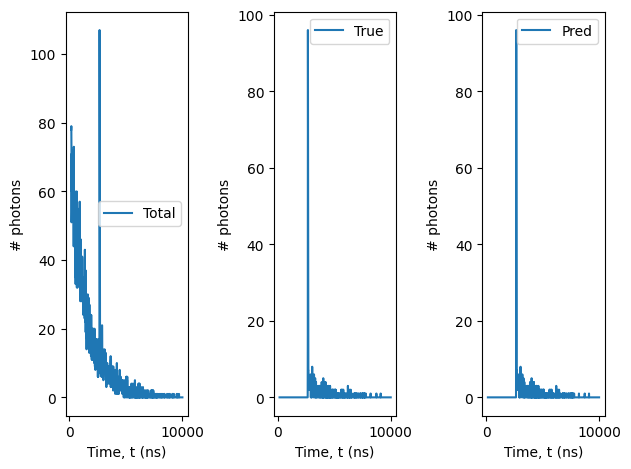

In [47]:
v = [Xexample_train[:,0], yexample_train, y_pred]
plotSignals(t, v, ['Total', 'True', 'Pred'], sep=True)

As we can see, the model is extracting practically the same signal in the 
prediction. We try with another signal:

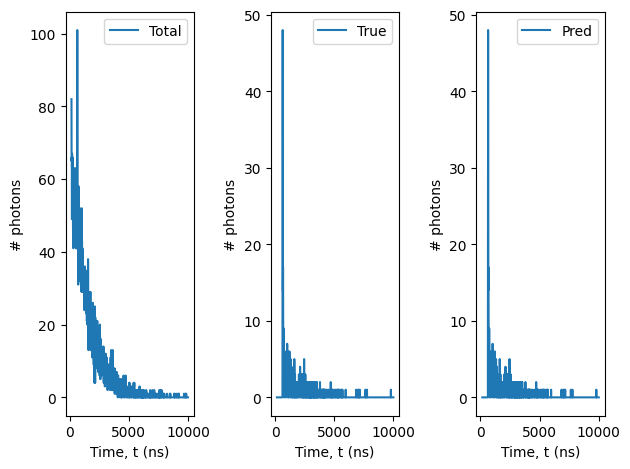

In [19]:
i = 120
best_svm = SVR(kernel='linear', C=1, degree=2, epsilon=0.0001)
Xexample_test = np.array([signals.iloc[i, t_idx].values, mu_signals.iloc[i, t_idx].values]).T
yexample_test = np.array(e_signals.iloc[i, t_idx].values).reshape(-1)

best_svm.fit(Xexample_train, yexample_train)
y_pred = best_svm.predict(Xexample_test)

v = [Xexample_test[:,0], yexample_test, y_pred]
plotSignals(t, v, ['Total', 'True', 'Pred'], sep=True)

We save this model, since it seems to work practically perfect...

In [20]:
MODELS = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*1)) 
MODELS = os.path.join(MODELS, 'models')

In [21]:
import pickle

with open(os.path.join(MODELS, 'best_svr.pkl'), "wb") as f:
    if input('Save model? (Y/N)')=='Y':
        pickle.dump(best_svm, f)

In [22]:
X = np.array([signals.iloc[:, t_idx].values, 
                   mu_signals.iloc[:, t_idx].values]).T
Y = np.array(e_signals.iloc[:,t_idx].values)

print(X.shape) # t, series, features
print(Y.shape) # series, t

e_found=0
for j in range(X.shape[1]): 
    q = quality(t)
    
    x_test = X[:,j,:]
    y_test = Y[j,:].reshape(-1)
    y_pred = best_svm.predict(x_test)
    
    if q._score_efound(y_test, y_pred): e_found+=1
    
print('Ratio e total found: {0}%'.format(e_found / Y.shape[0] * 100))

(985, 9325, 2)
(9325, 985)
Ratio e total found: 98.88471849865952%


In [23]:
X = np.array([signals.loc[e_idxs, t_idx].values, 
                   mu_signals.loc[e_idxs, t_idx].values]).T
Y = np.array(e_signals.loc[e_idxs,t_idx].values)

print(X.shape) # t, series, features
print(Y.shape) # series, t

e_found=0
for j in range(X.shape[1]): 
    q = quality(t)
    
    x_test = X[:,j,:]
    y_test = Y[j,:].reshape(-1)
    y_pred = best_svm.predict(x_test)
    
    if q._score_efound(y_test, y_pred): e_found+=1
    
print('Ratio e total found: {0}%'.format(e_found / Y.shape[0] * 100))

(985, 4223, 2)
(4223, 985)
Ratio e total found: 99.81056121240825%


### 4.2.4. <a id='toc4_2_4_'></a>[Test with real world data](#toc0_)

Now, we will take the total signal and we use it to calculate the $\mu$ signals:

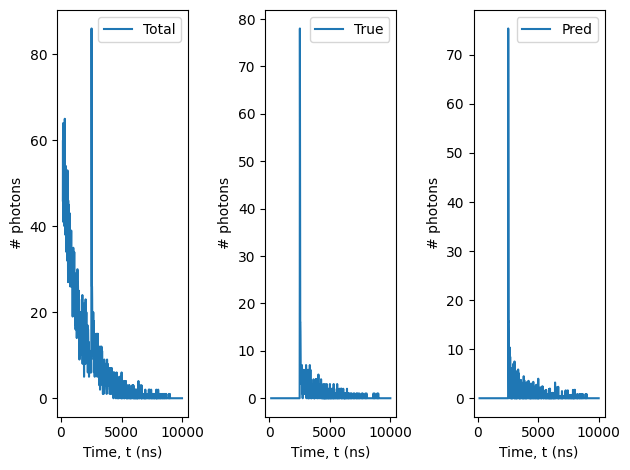

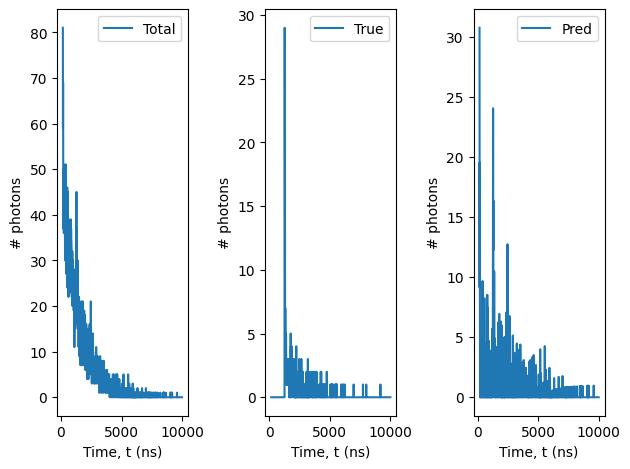

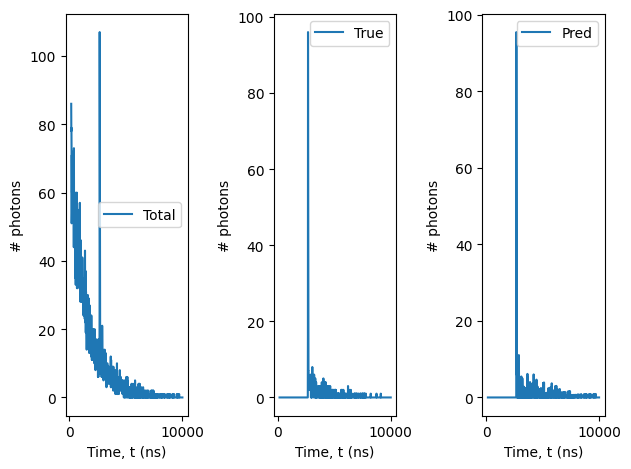

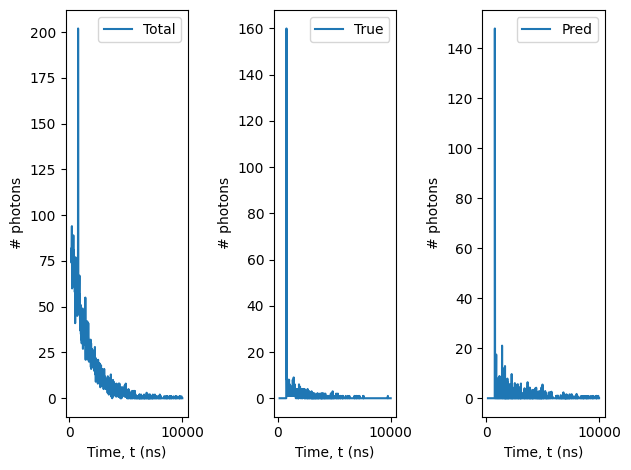

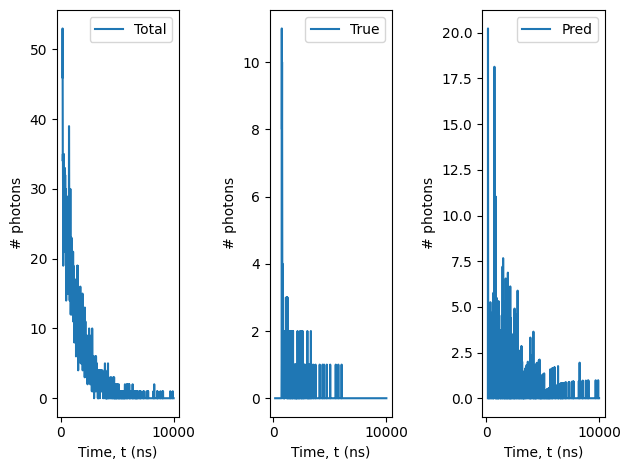

Ratio e total found: 68.52948141131897%
2894 4223


In [26]:
from decompose import greedyDecomposition

signals_arr = np.array(signals.loc[e_idxs, t_idx].values).T
Y = np.array(e_signals.loc[e_idxs,t_idx].values).T

e_found=0
for j in range(signals_arr.shape[1]):
    signal = signals_arr[:,j]
    e_signal = Y[:,j]
    
    decompose = greedyDecomposition(t, signal, e_signal)
    decompose.automaticFit()
    mu_signal = decompose.fit_signal
    
    x = np.array([signal, mu_signal]).T
    y = e_signal.reshape(-1)
    
    y_pred = best_svm.predict(x)
    
    if j<5: 
        y_pred_mod = np.array(y_pred)
        y_pred_mod[:np.argmax(y_pred_mod)]=0 # remove noise before e
        y_pred_mod[y_pred_mod<0]=0 # remove negative values
        v = [x[:,0], y, y_pred_mod]        
        plotSignals(t, v, ['Total', 'True', 'Pred'], sep=True)
    
    if q._score_efound(y, y_pred): e_found+=1
    
print('Ratio e total found: {0}%'.format(e_found / Y.shape[1] * 100))
print(e_found, Y.shape[1])